# Notebook to test SetFit performance

Check CUDA

In [2]:
import torch
if torch.cuda.is_available():    
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Load dataset and transform data

In [3]:
import pandas as pd
import numpy as np

dataFrame = pd.read_pickle(r'../data/7587_corrige.pkl')

In [4]:
subset = dataFrame[['jobTitle', 'description', 'label']].copy()

subset.reset_index(drop=True, inplace=True)
subset.replace('', np.nan, inplace=True)
subset.dropna(inplace=True)

subset['text'] = subset['jobTitle'] + ' ' + subset['description']
subset['label'] = np.where((subset["label"] < 3) | (subset["label"].isna()), 0, 1)
subset = subset[['text','label']]
subset

,text,label
2,Stagiaire ingénieur en intelligence artificiel...,1
3,Stagiaire en développement logiciel Développem...,0
4,Stagiaire en développement Web Création et évo...,0
5,Stagiaire en développement Web Portage d’une a...,0
6,Développeur Data / IA Développement d'applicat...,1
...,...,...
11281,Opérateur production Montage de transmission a...,0
11282,Opérateur production Montage de transmission a...,0
11283,Technicien réparation informatique Reparation ...,0
11284,Technicien réparation Reparation & maintenance...,0


Split between training and test set and truncate the dataset to simulate few-shot context

In [5]:
from datasets import Dataset

def split_train_test(dataset, ratio):
    test_set = dataset.sample(frac = ratio)
    train_set = dataset.drop(test_set.index)
    return train_set, test_set

train_set, test_set = split_train_test(subset, 0.2)

train_ds = Dataset.from_pandas(train_set, split="train")
test_ds = Dataset.from_pandas(test_set, split="test")

In [6]:
from setfit import sample_dataset

train_dataset = sample_dataset(train_ds, label_column="label", num_samples=10)
test_dataset = test_ds
print(train_dataset)

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 20
})


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


Load a pre trained sentence transformers to be used by SetFit

In [7]:
from setfit import SetFitModel

# Load SetFit model from Hub
model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")
model.to("cuda")

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


SetFitModel(model_body=SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
), model_head=LogisticRegression(), multi_target_strategy=None, normalize_embeddings=False, labels=None, model_card_data=SetFitModelCardData(language=None, license=None, tags=['setfit', 'sentence-transformers', 'text-classification', 'generated_from_setfit_trainer'], model_name='SetFit with sentence-transformers/paraphrase-mpnet-base-v2', model_id=None, dataset_name=None, dataset_id=None, dataset_revision=None, task_name=None, st_id='sentence-transformers/paraphrase-mpnet-base-v2', hyperparameters={}, eval_results_dict={}, eval_lines_list=[], metric_l

In [8]:
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import Trainer, TrainingArguments
from sklearn.metrics import f1_score, accuracy_score

# Create trainer

def compute_metrics(y_pred, y_test):
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return { 'accuracy': accuracy, 'f1': f1}

trainer_arguments = TrainingArguments(
	loss=CosineSimilarityLoss,
    batch_size=(8,2),
    num_iterations=20, # Number of text pairs to generate for contrastive learning
    num_epochs=(1,10) # Number of epochs to use for contrastive learning (for the transformer and for the classification head)
)

trainer = Trainer(
    model=model,
    args=trainer_arguments,
    metric=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Training and evaluation

In [9]:
# trainer.train()

How to save/load the fine tuned model

In [10]:
# metrics = trainer.evaluate()
# metrics

In [11]:
# model._save_pretrained(r'../models/setfit') # The given folder must exist

In [12]:
# model = SetFitModel._from_pretrained(r'../models/setfit')

A small example on unseen data

In [13]:
# preds = model(["Mon rôle chez DreamQuark, est de résoudre les problématiques des différents acteurs autour de la\nbanque et assurance (Churn, upsale, cross-sale etc.) à travers des techniques de Machine\nLearning/Deep learning","• Utilisation de Flask et d’Elasticsearch afin de créer une API\nREST pour faire des recherches sur des régions de\nplanètes."])
# print("predictions: ", preds,"expected: ",[1,0])

Free memory

In [14]:
del model
torch.cuda.empty_cache()

# Tests on hyper parameters

In [15]:
import gc

num_classes = 2

def get_transformer_model(model_name):
    model = SetFitModel.from_pretrained(model_name)
    gc.collect()
    torch.cuda.empty_cache()
    
    return model.to('cuda')

def init_trainer(model, loss, train_dataset, test_dataset):
    trainer_arguments = TrainingArguments(
        loss=loss,
        batch_size=(8,2),
        num_iterations=20, # Number of text pairs to generate for contrastive learning
        num_epochs=(1,10) # Number of epochs to use for contrastive learning (for the transformer and for the classification head)
    )

    trainer = Trainer(
        model=model,
        args=trainer_arguments,
        metric='f1',
        train_dataset=train_dataset,
        eval_dataset=test_dataset
    )
    return trainer

def setfit_f1_score(train_set, test_set, model_name, loss):   
    if len(train_set) <= 1 or len(test_set) <= 1:
        raise Exception
    
    model = get_transformer_model(model_name)
    trainer = init_trainer(model, loss, train_set, test_set)
    
    trainer.train()
    metrics = trainer.evaluate()
    
    del model
    del trainer
    torch.cuda.empty_cache()
    
    return metrics['f1']

In [16]:
from langdetect import detect

def filter_lang(df, lang):
    indices = []
    for i in range(len(df)):
        try:
            l = detect(df.iloc[i]["text"])
            if l == lang:
                indices.append(i)
        except:""
    
    return df.iloc[indices]

def filter_dataset(data, min_text_length=None, max_text_length=None, lang=None):
    if min_text_length is None:
        if max_text_length is None:
            filtered_data = data
        else:
            filtered_data = data[data['text'].str.split().apply(len) <= max_text_length]
    else:
        if max_text_length is None:
            filtered_data = data[data['text'].str.split().apply(len) >= min_text_length]
        else:
            filtered_data = data[data['text'].str.split().apply(len).between(min_text_length, max_text_length)]
            
    if not (lang is None):
        filtered_data = filter_lang(filtered_data, lang)
           
    return filtered_data

### N-Shots

In [18]:
results = []
n_values = [1,5,10,15,20]
temp = []

# Use the same subset of the dataset for all of the tests in the following loop
new_train_set = train_set.groupby('label').head(np.max(n_values))
new_train_set = Dataset.from_pandas(new_train_set, split="train")
new_test_set = Dataset.from_pandas(test_set, split="test")

for n_shot in n_values:
    try:
        train_set_n_shot = sample_dataset(new_train_set, label_column="label", num_samples=n_shot)
        results.append(setfit_f1_score(train_set_n_shot, new_test_set, "sentence-transformers/paraphrase-mpnet-base-v2", CosineSimilarityLoss))
        temp.append(n_shot)
    except: ""

n_values = temp

g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 80
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 10


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{'embedding_loss': 0.043, 'learning_rate': 2e-05, 'epoch': 0.1}
{'train_runtime': 5.5615, 'train_samples_per_second': 14.385, 'train_steps_per_second': 1.798, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 400
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 50


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

{'embedding_loss': 0.1273, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.02}


***** Running evaluation *****


{'embedding_loss': 0.0006, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 15.599, 'train_samples_per_second': 25.643, 'train_steps_per_second': 3.205, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 800
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 100


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

{'embedding_loss': 0.2586, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.01}
{'embedding_loss': 0.002, 'learning_rate': 1.1111111111111113e-05, 'epoch': 0.5}


***** Running evaluation *****


{'embedding_loss': 0.0003, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 30.8365, 'train_samples_per_second': 25.943, 'train_steps_per_second': 3.243, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/30 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1200
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 150


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

{'embedding_loss': 0.3041, 'learning_rate': 1.3333333333333334e-06, 'epoch': 0.01}
{'embedding_loss': 0.0042, 'learning_rate': 1.4814814814814815e-05, 'epoch': 0.33}
{'embedding_loss': 0.0004, 'learning_rate': 7.4074074074074075e-06, 'epoch': 0.67}
{'embedding_loss': 0.0004, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 47.724, 'train_samples_per_second': 25.145, 'train_steps_per_second': 3.143, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/40 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1600
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 200


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

{'embedding_loss': 0.3025, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}
{'embedding_loss': 0.0176, 'learning_rate': 1.6666666666666667e-05, 'epoch': 0.25}
{'embedding_loss': 0.0006, 'learning_rate': 1.1111111111111113e-05, 'epoch': 0.5}
{'embedding_loss': 0.0002, 'learning_rate': 5.555555555555557e-06, 'epoch': 0.75}
{'embedding_loss': 0.0001, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 59.699, 'train_samples_per_second': 26.801, 'train_steps_per_second': 3.35, 'epoch': 1.0}


***** Running evaluation *****


In [17]:
import matplotlib.pyplot as plt

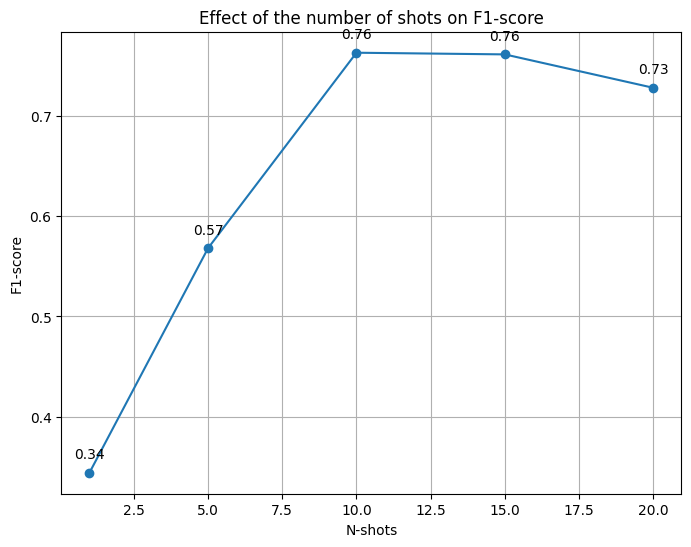

In [21]:
x = n_values
y = results
 
plt.figure(figsize=(8, 6))
plt.plot(x, y, marker='o', linestyle='-')
 
for i, (xi, yi) in enumerate(zip(x, y)):
    plt.annotate(f'{yi:.2f}', (xi, yi), textcoords="offset points", xytext=(0, 10), ha='center')
 
plt.title('Effect of the number of shots on F1-score')
plt.xlabel('N-shots')
plt.ylabel('F1-score')
 
plt.grid(True)
plt.show()

### Input length

In [22]:
results = {}
len_values = [(0,1),(0,3),(0,5),(0,10),(0,50),(0,100)]
new_test_set = Dataset.from_pandas(test_set, split="test")
nbIter = 5

for i in range(len(len_values)):
	results[f"[{len_values[i][0]},{len_values[i][1]}]"] = 0.0
results['all'] = 0.0
results['all but [0,5]'] = 0.0

# Repeat the tests multiple times because F1-score variations might be due to the examples chosen and not the input length of those examples
for iter in range(nbIter):
	print("Step:",iter,"/",nbIter)
	for i in range(len(len_values)):
		try:
			new_train_set = filter_dataset(train_set, len_values[i][0], len_values[i][1])
			new_train_set = Dataset.from_pandas(new_train_set, split="train")
			new_train_set = sample_dataset(new_train_set, label_column="label", num_samples=8, seed=(13*iter))
			results[f"[{len_values[i][0]},{len_values[i][1]}]"] += setfit_f1_score(new_train_set, new_test_set, "sentence-transformers/paraphrase-mpnet-base-v2", CosineSimilarityLoss)
		except:
			key = f"[{len_values[i][0]},{len_values[i][1]}]"
			if key in results:
				del results[key]
  
	# Additional tests (no length constraint and only data with a legnth greater than 5)
	new_train_set = Dataset.from_pandas(train_set, split="train")
	new_train_set = sample_dataset(new_train_set, label_column="label", num_samples=8)
	results['all'] += setfit_f1_score(new_train_set, new_test_set, "sentence-transformers/paraphrase-mpnet-base-v2", CosineSimilarityLoss)

	new_train_set = filter_dataset(train_set, 6)
	new_train_set = Dataset.from_pandas(new_train_set, split="train")
	new_train_set = sample_dataset(new_train_set, label_column="label", num_samples=8)
	results['all but [0,5]'] += setfit_f1_score(new_train_set, new_test_set, "sentence-transformers/paraphrase-mpnet-base-v2", CosineSimilarityLoss)

# Mean of F1-scores
for key in results.keys():
	results[key] /= nbIter

Step: 0 / 5


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this 

Map:   0%|          | 0/8 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 320
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/11 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 440
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 55


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

{'embedding_loss': 0.0797, 'learning_rate': 3.3333333333333333e-06, 'epoch': 0.02}
{'embedding_loss': 0.002, 'learning_rate': 2.0408163265306125e-06, 'epoch': 0.91}


***** Running evaluation *****


{'train_runtime': 4.724, 'train_samples_per_second': 93.141, 'train_steps_per_second': 11.643, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1654, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0018, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}


***** Running evaluation *****


{'train_runtime': 7.263, 'train_samples_per_second': 88.118, 'train_steps_per_second': 11.015, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1135, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0004, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 15.072, 'train_samples_per_second': 42.463, 'train_steps_per_second': 5.308, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1811, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0008, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 23.93, 'train_samples_per_second': 26.745, 'train_steps_per_second': 3.343, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1446, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0009, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 21.797, 'train_samples_per_second': 29.362, 'train_steps_per_second': 3.67, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1648, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0019, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 36.123, 'train_samples_per_second': 17.717, 'train_steps_per_second': 2.215, 'epoch': 1.0}


***** Running evaluation *****


Step: 1 / 5


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this 

Map:   0%|          | 0/11 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 440
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 55


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

{'embedding_loss': 0.1259, 'learning_rate': 3.3333333333333333e-06, 'epoch': 0.02}
{'embedding_loss': 0.0005, 'learning_rate': 2.0408163265306125e-06, 'epoch': 0.91}


***** Running evaluation *****


{'train_runtime': 4.628, 'train_samples_per_second': 95.074, 'train_steps_per_second': 11.884, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1608, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0008, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}


***** Running evaluation *****


{'train_runtime': 7.777, 'train_samples_per_second': 82.294, 'train_steps_per_second': 10.287, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.2043, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0007, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 14.762, 'train_samples_per_second': 43.355, 'train_steps_per_second': 5.419, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.2255, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0013, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 26.498, 'train_samples_per_second': 24.153, 'train_steps_per_second': 3.019, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1446, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0009, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 21.888, 'train_samples_per_second': 29.24, 'train_steps_per_second': 3.655, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1648, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0019, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 35.317, 'train_samples_per_second': 18.122, 'train_steps_per_second': 2.265, 'epoch': 1.0}


***** Running evaluation *****


Step: 2 / 5


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this 

Map:   0%|          | 0/11 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 440
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 55


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

{'embedding_loss': 0.1562, 'learning_rate': 3.3333333333333333e-06, 'epoch': 0.02}
{'embedding_loss': 0.0019, 'learning_rate': 2.0408163265306125e-06, 'epoch': 0.91}


***** Running evaluation *****


{'train_runtime': 4.533, 'train_samples_per_second': 97.066, 'train_steps_per_second': 12.133, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1154, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0017, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}


***** Running evaluation *****


{'train_runtime': 7.25, 'train_samples_per_second': 88.276, 'train_steps_per_second': 11.034, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1571, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0015, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}


***** Running evaluation *****


{'train_runtime': 15.664, 'train_samples_per_second': 40.858, 'train_steps_per_second': 5.107, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1395, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0012, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 21.758, 'train_samples_per_second': 29.414, 'train_steps_per_second': 3.677, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1446, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0009, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 21.957, 'train_samples_per_second': 29.148, 'train_steps_per_second': 3.643, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1648, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0019, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 35.303, 'train_samples_per_second': 18.129, 'train_steps_per_second': 2.266, 'epoch': 1.0}


***** Running evaluation *****


Step: 3 / 5


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this 

Map:   0%|          | 0/11 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 440
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 55


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

{'embedding_loss': 0.184, 'learning_rate': 3.3333333333333333e-06, 'epoch': 0.02}
{'embedding_loss': 0.002, 'learning_rate': 2.0408163265306125e-06, 'epoch': 0.91}


***** Running evaluation *****


{'train_runtime': 4.821, 'train_samples_per_second': 91.267, 'train_steps_per_second': 11.408, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1474, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0015, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}


***** Running evaluation *****


{'train_runtime': 7.494, 'train_samples_per_second': 85.402, 'train_steps_per_second': 10.675, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1438, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0007, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 15.822, 'train_samples_per_second': 40.45, 'train_steps_per_second': 5.056, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1454, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0006, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 23.738, 'train_samples_per_second': 26.961, 'train_steps_per_second': 3.37, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1446, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0009, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 21.861, 'train_samples_per_second': 29.276, 'train_steps_per_second': 3.659, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1648, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0019, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 35.388, 'train_samples_per_second': 18.085, 'train_steps_per_second': 2.261, 'epoch': 1.0}


***** Running evaluation *****


Step: 4 / 5


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this 

Map:   0%|          | 0/11 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 440
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 55


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

{'embedding_loss': 0.0915, 'learning_rate': 3.3333333333333333e-06, 'epoch': 0.02}
{'embedding_loss': 0.0013, 'learning_rate': 2.0408163265306125e-06, 'epoch': 0.91}


***** Running evaluation *****


{'train_runtime': 4.572, 'train_samples_per_second': 96.238, 'train_steps_per_second': 12.03, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.2257, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0037, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}


***** Running evaluation *****


{'train_runtime': 7.645, 'train_samples_per_second': 83.715, 'train_steps_per_second': 10.464, 'epoch': 1.0}


g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1683, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0074, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 15.338, 'train_samples_per_second': 41.726, 'train_steps_per_second': 5.216, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.2211, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0025, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 19.841, 'train_samples_per_second': 32.256, 'train_steps_per_second': 4.032, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1446, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0009, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 21.898, 'train_samples_per_second': 29.226, 'train_steps_per_second': 3.653, 'epoch': 1.0}


***** Running evaluation *****
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1648, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0019, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 35.383, 'train_samples_per_second': 18.088, 'train_steps_per_second': 2.261, 'epoch': 1.0}


***** Running evaluation *****


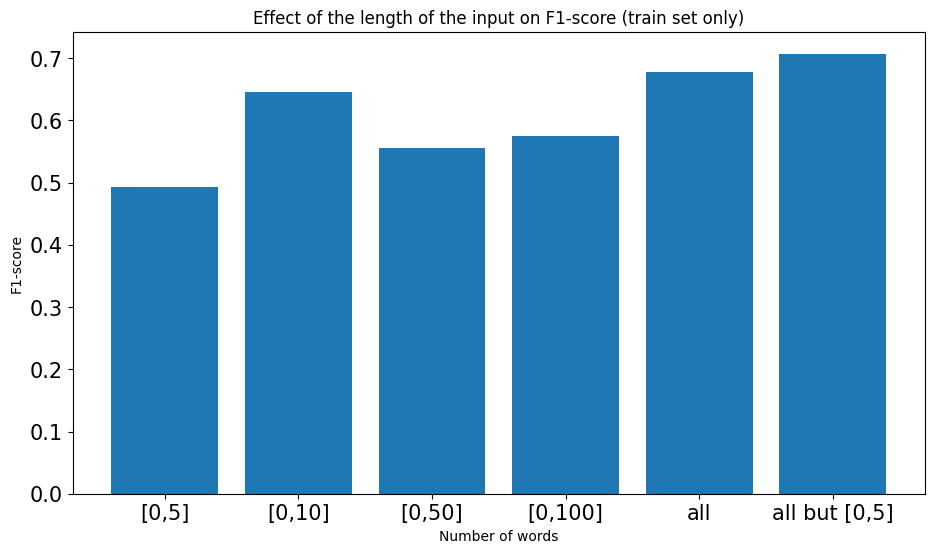

In [23]:
x = results.keys()
y = results.values()
 
plt.figure(figsize=(11, 6))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.bar(x, y)

plt.title('Effect of the length of the input on F1-score (train set only)')
plt.xlabel('Number of words')
plt.ylabel('F1-score')

plt.show()

### Distances

In [28]:
from sentence_transformers.losses import BatchAllTripletLoss

results = {}

new_train_set = Dataset.from_pandas(train_set, split="train")
new_train_set = sample_dataset(new_train_set, label_column="label", num_samples=8)
new_test_set = Dataset.from_pandas(test_set, split="test")

results['Triplet'] = setfit_f1_score(new_train_set, new_test_set, "sentence-transformers/paraphrase-mpnet-base-v2", BatchAllTripletLoss)
results['Cosine'] = setfit_f1_score(new_train_set, new_test_set, "sentence-transformers/paraphrase-mpnet-base-v2", CosineSimilarityLoss)

g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 16
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 2


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'embedding_loss': 0.1888, 'learning_rate': 2e-05, 'epoch': 0.5}
{'train_runtime': 6.419, 'train_samples_per_second': 2.493, 'train_steps_per_second': 0.312, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1821, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0015, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 435.7708, 'train_samples_per_second': 1.469, 'train_steps_per_second': 0.184, 'epoch': 1.0}


***** Running evaluation *****


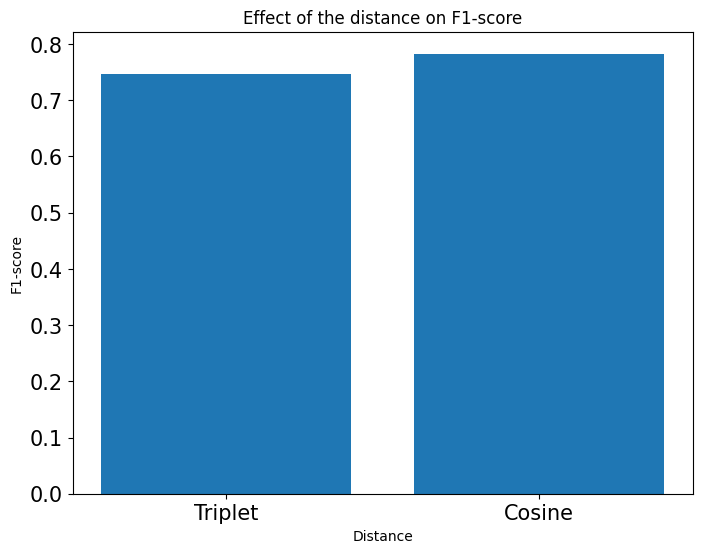

In [29]:
x = results.keys()
y = results.values()

plt.figure(figsize=(8, 6))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.bar(x, y)

plt.title('Effect of the distance on F1-score')
plt.xlabel('Distance')
plt.ylabel('F1-score')

plt.show()

### Language

In [33]:
fr_train_set_panda = filter_dataset(train_set, lang='fr')
fr_train_set = Dataset.from_pandas(fr_train_set_panda, split="train")
fr_train_set = sample_dataset(fr_train_set, label_column="label", num_samples=8)
fr_test_set_panda = filter_dataset(test_set, lang='fr')
fr_test_set = Dataset.from_pandas(fr_test_set_panda, split="test")

en_train_set_panda = filter_dataset(train_set, lang='en')
en_train_set = Dataset.from_pandas(en_train_set_panda, split="train")
en_train_set = sample_dataset(en_train_set, label_column="label", num_samples=8)
en_test_set_panda = filter_dataset(test_set, lang='en')
en_test_set = Dataset.from_pandas(en_test_set_panda, split="test")

mix_train_set = pd.concat([fr_train_set_panda, en_train_set_panda])
mix_train_set = Dataset.from_pandas(mix_train_set, split="test")
mix_train_set = sample_dataset(mix_train_set, label_column="label", num_samples=8)
mix_test_set = pd.concat([fr_test_set_panda, en_test_set_panda])
mix_test_set = Dataset.from_pandas(mix_test_set, split="test")

results = {}

results['fr'] = setfit_f1_score(fr_train_set, fr_test_set, "sentence-transformers/paraphrase-mpnet-base-v2", CosineSimilarityLoss)
results['en'] = setfit_f1_score(en_train_set, en_test_set, "sentence-transformers/paraphrase-mpnet-base-v2", CosineSimilarityLoss)
results['both'] = setfit_f1_score(mix_train_set, mix_test_set, "sentence-transformers/paraphrase-mpnet-base-v2", CosineSimilarityLoss)

g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this 

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1607, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0024, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 34.588, 'train_samples_per_second': 18.504, 'train_steps_per_second': 2.313, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1773, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0024, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 32.1601, 'train_samples_per_second': 19.9, 'train_steps_per_second': 2.488, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1313, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0012, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 102.6589, 'train_samples_per_second': 6.234, 'train_steps_per_second': 0.779, 'epoch': 1.0}


***** Running evaluation *****


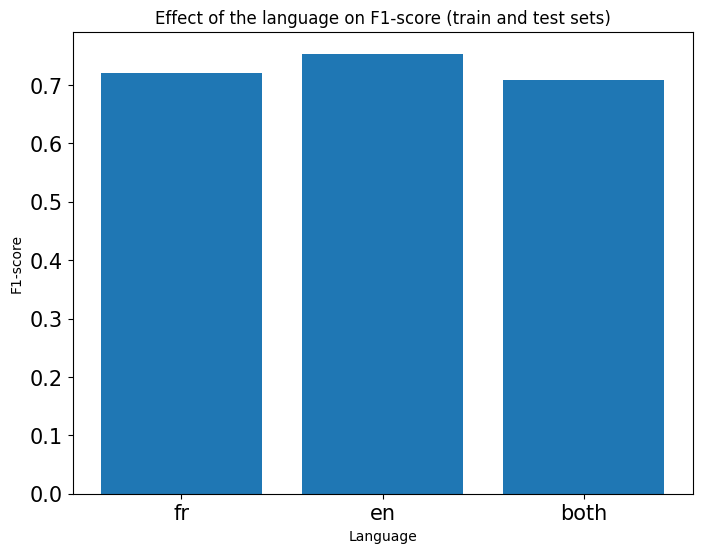

In [34]:
x = results.keys()
y = results.values()

plt.figure(figsize=(8, 6))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.bar(x, y)

plt.title('Effect of the language on F1-score (train and test sets)')
plt.xlabel('Language')
plt.ylabel('F1-score')

plt.show()

### Sentence transformers

Test SetFit with different ST models

In [34]:
results = {}
models = {
	"paraphrase-mpnet-base-v2": "sentence-transformers/paraphrase-mpnet-base-v2",
 	"all-MiniLM-L6-v2": "sentence-transformers/all-MiniLM-L6-v2",
	"paraphrase-multilingual-MiniLM-L12-v2": "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
	"paraphrase-multilingual-mpnet-base-v2": "sentence-transformers/paraphrase-multilingual-mpnet-base-v2",
	"multilingual-e5-small": "intfloat/multilingual-e5-small",
	"all-distilroberta-v1": "sentence-transformers/all-distilroberta-v1",
	"msmarco-distilbert-dot-v5": "sentence-transformers/msmarco-distilbert-dot-v5",
 	"bge-small-en-v1.5" : "BAAI/bge-small-en-v1.5"
}
temp = []

# Use the same subset of the dataset for all of the tests in the following loop
new_train_set = Dataset.from_pandas(train_set, split="train")
new_train_set = sample_dataset(new_train_set, label_column="label", num_samples=8)
new_test_set = Dataset.from_pandas(test_set, split="test")

for key, full_model_name in models.items():
    try:
        results[key] = setfit_f1_score(new_train_set, new_test_set, full_model_name, CosineSimilarityLoss)
    except: ""

g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))


config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\robin\.cache\huggingface\hub\models--BAAI--bge-small-en-v1.5. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.2045, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0391, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}


***** Running evaluation *****


{'train_runtime': 9.078, 'train_samples_per_second': 70.5, 'train_steps_per_second': 8.813, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.097, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0015, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 23.373, 'train_samples_per_second': 27.382, 'train_steps_per_second': 3.423, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1283, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0334, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}


***** Running evaluation *****


{'train_runtime': 4.89, 'train_samples_per_second': 130.879, 'train_steps_per_second': 16.36, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.0987, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0077, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}


***** Running evaluation *****


{'train_runtime': 9.4905, 'train_samples_per_second': 67.436, 'train_steps_per_second': 8.429, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.0997, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0007, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'train_runtime': 23.213, 'train_samples_per_second': 27.571, 'train_steps_per_second': 3.446, 'epoch': 1.0}


***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.3599, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0545, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}


***** Running evaluation *****


{'train_runtime': 10.974, 'train_samples_per_second': 58.32, 'train_steps_per_second': 7.29, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.1513, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0027, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}


***** Running evaluation *****


{'train_runtime': 14.975, 'train_samples_per_second': 42.738, 'train_steps_per_second': 5.342, 'epoch': 1.0}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 80


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'embedding_loss': 0.2782, 'learning_rate': 2.5e-06, 'epoch': 0.01}
{'embedding_loss': 0.0292, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}


***** Running evaluation *****


{'train_runtime': 11.9459, 'train_samples_per_second': 53.575, 'train_steps_per_second': 6.697, 'epoch': 1.0}


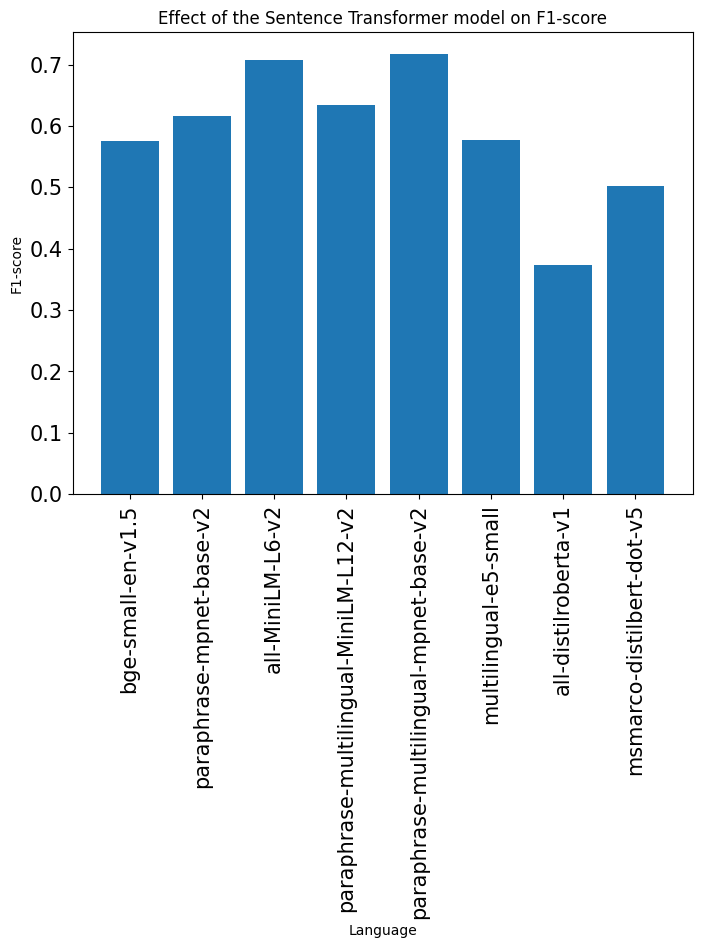

In [35]:
x = results.keys()
y = results.values()

plt.figure(figsize=(8, 6))
plt.xticks(fontsize=15, rotation='vertical')
plt.yticks(fontsize=15)
plt.bar(x, y)

plt.title('Effect of the Sentence Transformer model on F1-score')
plt.xlabel('Language')
plt.ylabel('F1-score')

plt.show()

### Hyperparameter Optimization (with optuna)

In [16]:
from typing import Dict, Any, Union
from optuna import Trial

def model_init(params: Dict[str, Any]) -> SetFitModel:
    params = params or {}
    max_iter = params.get("max_iter", 100)
    solver = params.get("solver", "liblinear")
    params = {
        "head_params": {
            "max_iter": max_iter,
            "solver": solver,
        }
    }
    return SetFitModel.from_pretrained("sentence-transformers/paraphrase-multilingual-mpnet-base-v2", **params)

def hp_space(trial: Trial) -> Dict[str, Union[float, int, str]]:
    return {
        "body_learning_rate": trial.suggest_float("body_learning_rate", 1e-6, 1e-3, log=True),
        "num_epochs": trial.suggest_int("num_epochs", 1, 2),
        "batch_size": trial.suggest_categorical("batch_size", [8, 16, 32]),
        "seed": trial.suggest_int("seed", 1, 40),
        "max_iter": trial.suggest_int("max_iter", 50, 300),
        "solver": trial.suggest_categorical("solver", ["newton-cg", "lbfgs", "liblinear"]),
    }
    
new_train_set = Dataset.from_pandas(train_set, split="train")
new_train_set = sample_dataset(new_train_set, label_column="label", num_samples=8)
new_test_set = Dataset.from_pandas(test_set, split="test")

trainer = Trainer(
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    model_init=model_init,
    metric='f1',
)

best_run = trainer.hyperparameter_search(direction="maximize", hp_space=hp_space, n_trials=10)

g:\CYTech\ING2\ProjetLinkedin\2024_02_25\linkedin-work-experience-classification\.venv\lib\site-packages\setfit\data.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.apply(lambda x: x.sample(min(num_samples, len(x)), random_state=seed))
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

[I 2024-03-04 17:21:16,902] A new study created in memory with name: no-name-f73d1afc-bc72-409e-8f14-16ebb235598d
Trial: {'body_learning_rate': 2.9117741675118267e-06, 'num_epochs': 1, 'batch_size': 16, 'seed': 26, 'max_iter': 86, 'solver': 'newton-cg'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num unique pairs = 220
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 14


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

{'embedding_loss': 0.1722, 'learning_rate': 1.4558870837559133e-06, 'epoch': 0.07}
{'train_runtime': 11.4786, 'train_samples_per_second': 19.515, 'train_steps_per_second': 1.22, 'epoch': 1.0}


***** Running evaluation *****
[I 2024-03-04 17:21:35,002] Trial 0 finished with value: 0.6636568848758465 and parameters: {'body_learning_rate': 2.9117741675118267e-06, 'num_epochs': 1, 'batch_size': 16, 'seed': 26, 'max_iter': 86, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.6636568848758465.
Trial: {'body_learning_rate': 0.0008181196689548183, 'num_epochs': 1, 'batch_size': 32, 'seed': 5, 'max_iter': 256, 'solver': 'lbfgs'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num unique pairs = 220
  Batch size = 32
  Num epochs = 1
  Total optimization steps = 7


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

{'embedding_loss': 0.2087, 'learning_rate': 0.0008181196689548183, 'epoch': 0.14}


***** Running evaluation *****


{'train_runtime': 11.1959, 'train_samples_per_second': 20.007, 'train_steps_per_second': 0.625, 'epoch': 1.0}


[I 2024-03-04 17:21:53,152] Trial 1 finished with value: 0.3076923076923077 and parameters: {'body_learning_rate': 0.0008181196689548183, 'num_epochs': 1, 'batch_size': 32, 'seed': 5, 'max_iter': 256, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.6636568848758465.
Trial: {'body_learning_rate': 0.00013509456533855672, 'num_epochs': 1, 'batch_size': 8, 'seed': 22, 'max_iter': 212, 'solver': 'lbfgs'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num unique pairs = 220
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 28


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'embedding_loss': 0.26, 'learning_rate': 4.503152177951891e-05, 'epoch': 0.04}
{'train_runtime': 37.5767, 'train_samples_per_second': 5.961, 'train_steps_per_second': 0.745, 'epoch': 1.0}


***** Running evaluation *****
[I 2024-03-04 17:22:46,999] Trial 2 finished with value: 0.5830388692579506 and parameters: {'body_learning_rate': 0.00013509456533855672, 'num_epochs': 1, 'batch_size': 8, 'seed': 22, 'max_iter': 212, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.6636568848758465.
Trial: {'body_learning_rate': 0.00018664690502650114, 'num_epochs': 1, 'batch_size': 8, 'seed': 4, 'max_iter': 240, 'solver': 'lbfgs'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num unique pairs = 220
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 28


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'embedding_loss': 0.2414, 'learning_rate': 6.221563500883371e-05, 'epoch': 0.04}
{'train_runtime': 36.014, 'train_samples_per_second': 6.22, 'train_steps_per_second': 0.777, 'epoch': 1.0}


***** Running evaluation *****
[I 2024-03-04 17:23:41,463] Trial 3 finished with value: 0.7320574162679426 and parameters: {'body_learning_rate': 0.00018664690502650114, 'num_epochs': 1, 'batch_size': 8, 'seed': 4, 'max_iter': 240, 'solver': 'lbfgs'}. Best is trial 3 with value: 0.7320574162679426.
Trial: {'body_learning_rate': 4.877068740486535e-06, 'num_epochs': 1, 'batch_size': 8, 'seed': 19, 'max_iter': 275, 'solver': 'liblinear'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num unique pairs = 220
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 28


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'embedding_loss': 0.2511, 'learning_rate': 1.6256895801621783e-06, 'epoch': 0.04}


***** Running evaluation *****


{'train_runtime': 28.3272, 'train_samples_per_second': 7.908, 'train_steps_per_second': 0.988, 'epoch': 1.0}


[I 2024-03-04 17:24:24,197] Trial 4 finished with value: 0.6579520697167756 and parameters: {'body_learning_rate': 4.877068740486535e-06, 'num_epochs': 1, 'batch_size': 8, 'seed': 19, 'max_iter': 275, 'solver': 'liblinear'}. Best is trial 3 with value: 0.7320574162679426.
Trial: {'body_learning_rate': 2.2251851334406082e-05, 'num_epochs': 1, 'batch_size': 32, 'seed': 5, 'max_iter': 295, 'solver': 'lbfgs'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num unique pairs = 220
  Batch size = 32
  Num epochs = 1
  Total optimization steps = 7


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

{'embedding_loss': 0.2087, 'learning_rate': 2.2251851334406082e-05, 'epoch': 0.14}
{'train_runtime': 37.548, 'train_samples_per_second': 5.966, 'train_steps_per_second': 0.186, 'epoch': 1.0}


***** Running evaluation *****
[I 2024-03-04 17:25:26,081] Trial 5 finished with value: 0.7198067632850241 and parameters: {'body_learning_rate': 2.2251851334406082e-05, 'num_epochs': 1, 'batch_size': 32, 'seed': 5, 'max_iter': 295, 'solver': 'lbfgs'}. Best is trial 3 with value: 0.7320574162679426.
Trial: {'body_learning_rate': 1.8496506449690533e-06, 'num_epochs': 1, 'batch_size': 8, 'seed': 9, 'max_iter': 101, 'solver': 'liblinear'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num unique pairs = 220
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 28


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'embedding_loss': 0.2562, 'learning_rate': 6.165502149896844e-07, 'epoch': 0.04}
{'train_runtime': 45.6783, 'train_samples_per_second': 4.904, 'train_steps_per_second': 0.613, 'epoch': 1.0}


***** Running evaluation *****
[I 2024-03-04 17:26:24,253] Trial 6 finished with value: 0.615071283095723 and parameters: {'body_learning_rate': 1.8496506449690533e-06, 'num_epochs': 1, 'batch_size': 8, 'seed': 9, 'max_iter': 101, 'solver': 'liblinear'}. Best is trial 3 with value: 0.7320574162679426.
Trial: {'body_learning_rate': 0.00013097553301718564, 'num_epochs': 1, 'batch_size': 8, 'seed': 19, 'max_iter': 202, 'solver': 'newton-cg'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num unique pairs = 220
  Batch size = 8
  Num epochs = 1
  Total optimization steps = 28


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

{'embedding_loss': 0.2511, 'learning_rate': 4.3658511005728544e-05, 'epoch': 0.04}
{'train_runtime': 15.504, 'train_samples_per_second': 14.448, 'train_steps_per_second': 1.806, 'epoch': 1.0}


***** Running evaluation *****
[I 2024-03-04 17:26:50,853] Trial 7 finished with value: 0.6910755148741419 and parameters: {'body_learning_rate': 0.00013097553301718564, 'num_epochs': 1, 'batch_size': 8, 'seed': 19, 'max_iter': 202, 'solver': 'newton-cg'}. Best is trial 3 with value: 0.7320574162679426.
Trial: {'body_learning_rate': 3.526912512870353e-05, 'num_epochs': 2, 'batch_size': 8, 'seed': 10, 'max_iter': 87, 'solver': 'newton-cg'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num unique pairs = 220
  Batch size = 8
  Num epochs = 2
  Total optimization steps = 56


  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

{'embedding_loss': 0.2579, 'learning_rate': 5.878187521450588e-06, 'epoch': 0.04}
{'embedding_loss': 0.0004, 'learning_rate': 4.232295015444423e-06, 'epoch': 1.79}
{'train_runtime': 36.3178, 'train_samples_per_second': 12.336, 'train_steps_per_second': 1.542, 'epoch': 2.0}


***** Running evaluation *****
[I 2024-03-04 17:27:51,318] Trial 8 finished with value: 0.637065637065637 and parameters: {'body_learning_rate': 3.526912512870353e-05, 'num_epochs': 2, 'batch_size': 8, 'seed': 10, 'max_iter': 87, 'solver': 'newton-cg'}. Best is trial 3 with value: 0.7320574162679426.
Trial: {'body_learning_rate': 5.0317673348723905e-05, 'num_epochs': 1, 'batch_size': 16, 'seed': 4, 'max_iter': 281, 'solver': 'liblinear'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num unique pairs = 220
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 14


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

{'embedding_loss': 0.1821, 'learning_rate': 2.5158836674361953e-05, 'epoch': 0.07}
{'train_runtime': 31.6196, 'train_samples_per_second': 7.084, 'train_steps_per_second': 0.443, 'epoch': 1.0}


***** Running evaluation *****
[I 2024-03-04 17:28:38,542] Trial 9 finished with value: 0.7628361858190709 and parameters: {'body_learning_rate': 5.0317673348723905e-05, 'num_epochs': 1, 'batch_size': 16, 'seed': 4, 'max_iter': 281, 'solver': 'liblinear'}. Best is trial 9 with value: 0.7628361858190709.


In [17]:
print(best_run)

BestRun(run_id='9', objective=0.7628361858190709, hyperparameters={'body_learning_rate': 5.0317673348723905e-05, 'num_epochs': 1, 'batch_size': 16, 'seed': 4, 'max_iter': 281, 'solver': 'liblinear'}, backend=<optuna.study.study.Study object at 0x000001CC0398F520>)


In [18]:
trainer.apply_hyperparameters(best_run.hyperparameters, final_model=True)
trainer.train()

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num unique pairs = 220
  Batch size = 16
  Num epochs = 1
  Total optimization steps = 14


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

{'embedding_loss': 0.1821, 'learning_rate': 2.5158836674361953e-05, 'epoch': 0.07}
{'train_runtime': 21.3906, 'train_samples_per_second': 10.472, 'train_steps_per_second': 0.654, 'epoch': 1.0}


In [19]:
trainer.evaluate()

***** Running evaluation *****


{'f1': 0.7628361858190709}